In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import datetime
import pandas as pd
import requests
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
import plotly.express as px

In [3]:
mpl.rcParams['figure.figsize']=(10,8)
mpl.rcParams['axes.grid']=False


In [4]:
df=pd.read_csv('https://raw.githubusercontent.com/srivatsan88/YouTubeLI/master/dataset/amazon_revenue_profit.csv')

In [5]:
df.head()

,Quarter,Revenue,Net Income
0,3/31/2020,75452,2535
1,12/31/2019,87437,3268
2,9/30/2019,69981,2134
3,6/30/2019,63404,2625
4,3/31/2019,59700,3561


**The above dataset gives the quarter revenue of each years in Amazon,We are going to build a model to predict the future revenue of the company**

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61 entries, 0 to 60
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Quarter     61 non-null     object
 1   Revenue     61 non-null     int64 
 2   Net Income  61 non-null     int64 
dtypes: int64(2), object(1)
memory usage: 1.6+ KB


**As quareter field is of object type, converting that to date type**

In [7]:
df['Quarter']=pd.to_datetime(df['Quarter'])

In [8]:
df.shape

(61, 3)

In [9]:
df.isnull().any()

Quarter       False
Revenue       False
Net Income    False
dtype: bool

In [10]:
fig = px.line(df,x='Quarter',y='Revenue',title='Amazon profits')

fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=1,label='1m',step='month',stepmode='backward'),
            dict(count=2,label='6m',step='month',stepmode='backward'),
            dict(count=3,label='6mYTD',step='month',stepmode='backward'),
            dict(count=4,label='2y',step='year',stepmode='backward'),
            dict(count=5,label='3y',step='year',stepmode='backward'),
            dict(step='all')
        ])
    )
)
fig.show()

**we can see that there is a positive trend in the data and the time series is not stationary about mean, and there is seasonality at the end of each year.**

# Prophet model

In [11]:
from fbprophet import Prophet

In [12]:
amazon_df=df.reset_index()[['Quarter','Revenue']].rename({'Quarter':'ds','Revenue':'y'},axis='columns')

In [13]:
amazon_df.head()

,ds,y
0,2020-03-31,75452
1,2019-12-31,87437
2,2019-09-30,69981
3,2019-06-30,63404
4,2019-03-31,59700


In [14]:
amazon_df.tail()

,ds,y
56,2006-03-31,2279
57,2005-12-31,2977
58,2005-09-30,1858
59,2005-06-30,1753
60,2005-03-31,1902


# Train test split

In [15]:
train=amazon_df[(amazon_df['ds']>='2005-03-31')&(amazon_df['ds']<='2019-03-31')]
test=amazon_df[amazon_df['ds']>'2019-03-31']

In [16]:
train.shape

(57, 2)

In [17]:
test.shape

(4, 2)

In [18]:
model=Prophet(interval_width=0.95)

In [19]:
model.fit(train)

In [20]:
future=model.make_future_dataframe(periods=4,freq='Q') #as the time stamp is Quaterly & 4 is for test data records
future


,ds
0,2005-03-31
1,2005-06-30
2,2005-09-30
3,2005-12-31
4,2006-03-31
...,...
56,2019-03-31
57,2019-06-30
58,2019-09-30
59,2019-12-31


In [21]:
forecast=model.predict(future)

In [22]:
forecast[['ds','yhat','yhat_lower','yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
56,2019-03-31,61089.496722,56911.038714,64967.433956
57,2019-06-30,63195.117248,58978.568983,67103.059801
58,2019-09-30,66153.769201,61733.139815,69979.979438
59,2019-12-31,74249.538212,70456.968638,78091.103370
60,2020-03-31,70663.367647,66625.329478,74816.633378


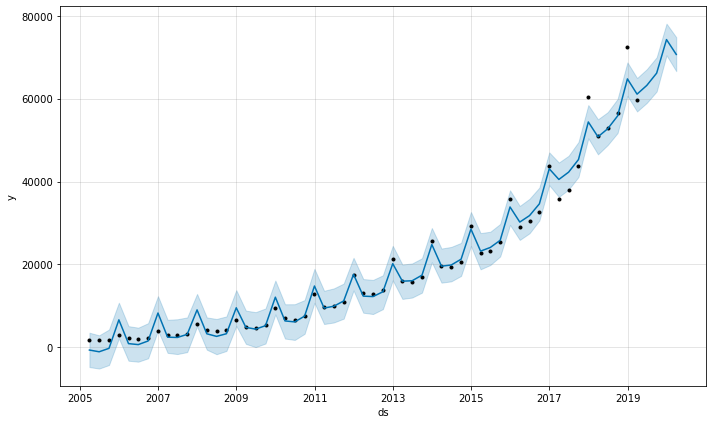

In [23]:
fig1=model.plot(forecast)

**We can able to find that the yhat which is the model prediction doesn't capture the time series data well, because there is variations in data during the seasonality and there are some wrong predictions too apart from the confidence interval**

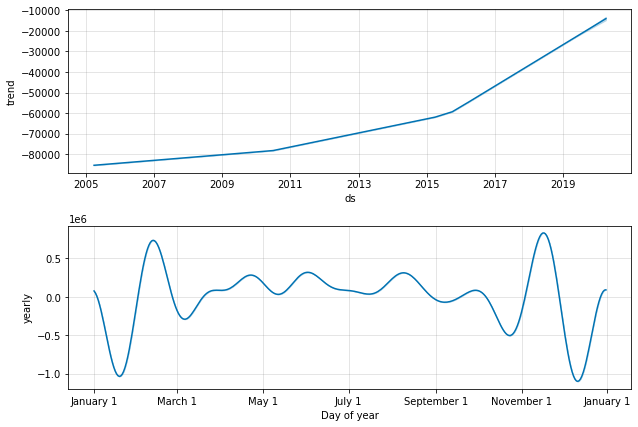

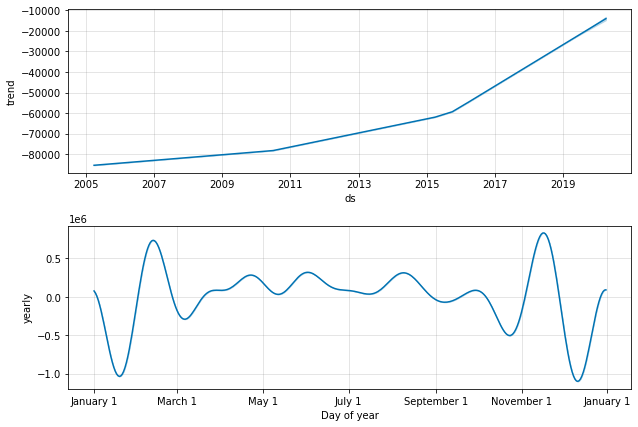

In [24]:
model.plot_components(forecast)

**From the plots, we can understand that there is seasonality in the end of December and start of january**

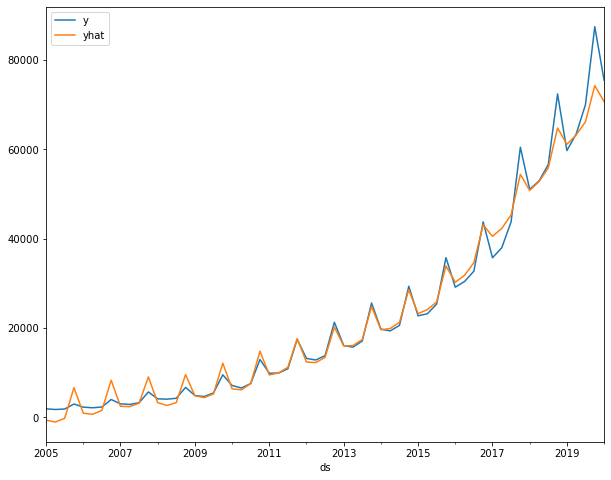

In [25]:
pd.concat([amazon_df.set_index('ds')['y'],forecast.set_index('ds')['yhat']],axis=1).plot()

# Retraining

**We are going to retrain the model such that it capture the seasonality at the year end and start, and the trend correctly**

In [26]:
holiday_sale=pd.DataFrame({
    'holiday':'dec_jan_sale',
    'ds':pd.to_datetime(['2019-12-31',
                        '2018-12-31',
                        '2017-12-31',
                        '2016-12-31',
                        '2015-12-31',
                        '2014-12-31',
                        '2013-12-31',
                        '2012-12-31',
                        '2011-12-31',
                        '2010-12-31',
                        '2009-12-31',
                        '2008-12-31',
                        '2007-12-31',
                        '2006-12-31',
                        '2005-12-31']),
    'lower_window':0,
    'upper_window':1,
})

In [27]:
holiday_sale

,holiday,ds,lower_window,upper_window
0,dec_jan_sale,2019-12-31,0,1
1,dec_jan_sale,2018-12-31,0,1
2,dec_jan_sale,2017-12-31,0,1
3,dec_jan_sale,2016-12-31,0,1
4,dec_jan_sale,2015-12-31,0,1
5,dec_jan_sale,2014-12-31,0,1
6,dec_jan_sale,2013-12-31,0,1
7,dec_jan_sale,2012-12-31,0,1
8,dec_jan_sale,2011-12-31,0,1
9,dec_jan_sale,2010-12-31,0,1


## Additive - no trend and stationary
## Multiplicative - trend and non stationary

**Here the model is multiplicative as there is trend and seasonality**

In [28]:
model2=Prophet(holidays=holiday_sale,seasonality_mode='multiplicative',interval_width=0.95)

In [29]:
model2.fit(train)

In [30]:
forecast=model2.predict(future)

In [31]:
forecast[['ds','yhat','yhat_lower','yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
56,2019-03-31,60098.589527,58351.815604,61857.786672
57,2019-06-30,62627.734827,60672.925061,64353.872651
58,2019-09-30,67792.982748,65948.418783,69601.013176
59,2019-12-31,89317.926197,87306.571351,91241.287111
60,2020-03-31,66836.358707,64776.214362,69025.719099


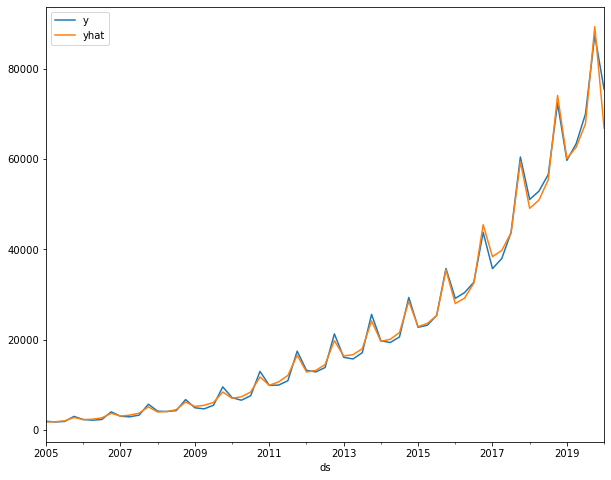

In [32]:
pd.concat([amazon_df.set_index('ds')['y'],forecast.set_index('ds')['yhat']],axis=1).plot()

**This model is pretty good than the previous one, it captures the trend and seasonality ( holiday sales) very well**

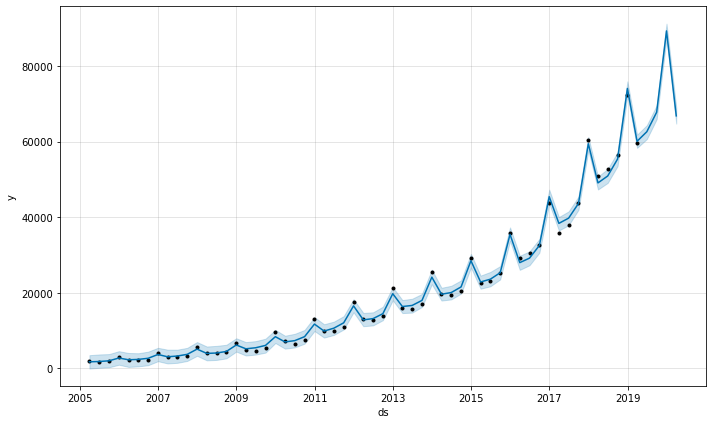

In [33]:
figure=model2.plot(forecast)

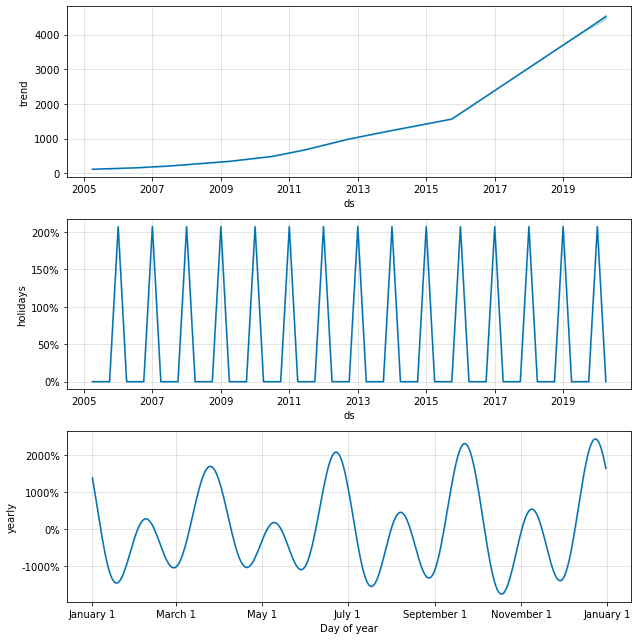

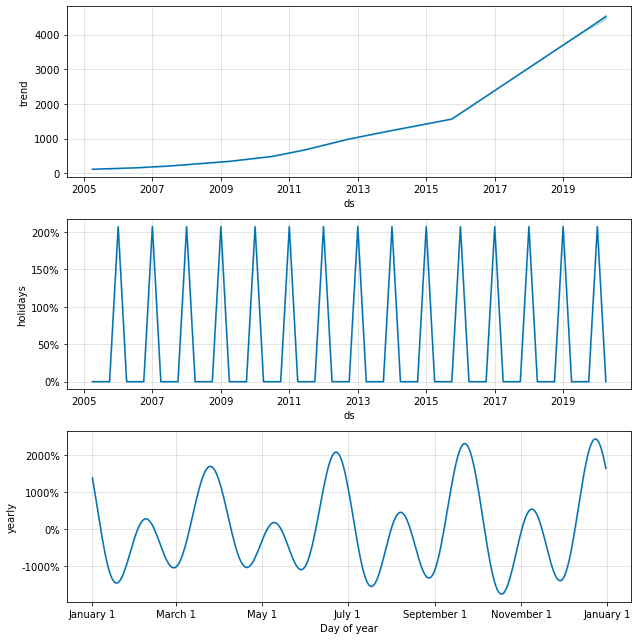

In [34]:
model2.plot_components(forecast)

# Test prediction

In [35]:
ypred=model2.predict(test)

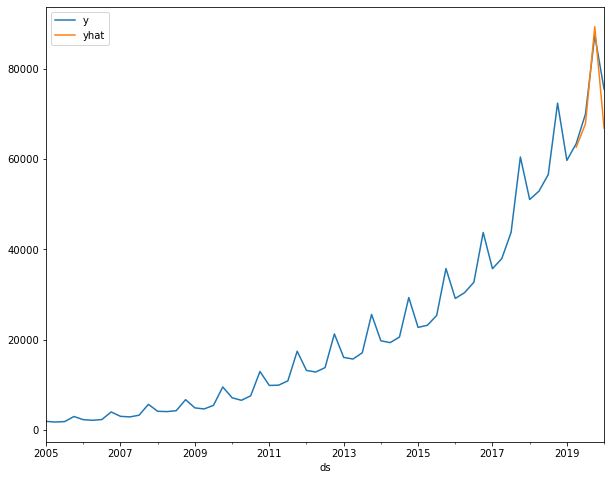

In [36]:
pd.concat([amazon_df.set_index('ds')['y'],ypred.set_index('ds')['yhat']],axis=1).plot()

**It works very well on the test data too ............... : )**